In [1]:
%matplotlib notebook
import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
from torch.autograd import Variable
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
from collections import Counter
import torch.nn.functional as F
import time
import h5py
import seaborn as sns
import os
import scipy
from scipy import io

plt.rc('font',family='Times New Roman', size=12)

In [2]:
patience = 20
epochs = 250
tra_num = 901
val_num = 99
part_num = 100
category = 6
batch_size = 32
num_cell = 32
learning_rate = 3e-4
threshold = 1e-4
realdata_num = 1
start_fm = 16
syn_num = part_num*category
total_num = tra_num + val_num

#noise_levels = [0.02, 0.04]
dataFile = './data_cengzhaung/data{}.mat'
syn_dataFile = './data_cengzhaungceshiji/data{}.mat'
#real_dataFile = './data/real/data{}.mat'
#model_File = './data/parameters_GavI.pth'
#G = torch.Tensor(np.nan_to_num(h5py.File('./G.mat', 'r')['G'].value)).T

In [3]:
#模型保存文件夹及文件路径
model_dir = './models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model_File = os.path.join(model_dir, "cengzhaung_duibi.pth")

In [4]:
def colorma():
    cdict = ["#F2F2F2", "#D1FEFE", "#00FEF9", "#00FDFE", "#50FB7F", "#D3F821", "#FFDE00", "#FF9D00", "#F03A00", "#E10000"] 
    return colors.ListedColormap(cdict, 'indexed')

In [5]:
class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=True),
                    nn.BatchNorm2d(out_channels),
                    nn.ELU(inplace=True),
                    nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=True),
                    nn.BatchNorm2d(out_channels),
                    nn.ELU(inplace=True))
        
    def forward(self, x):
        x = self.conv(x)
        return x

class CNNnet(nn.Module):
    
    def __init__(self):
        super(CNNnet, self).__init__()
             
        self.double_conv1 = double_conv(1, start_fm, 3, 1, 1)
        self.double_conv2 = double_conv(start_fm, start_fm * 2, 3, 1, 1)
        self.final = nn.Sequential(
                    nn.Conv2d(32, 32, kernel_size=1, padding=0, bias=True),
                    nn.BatchNorm2d(32),
                    nn.Sigmoid())
        

    
    def forward(self, inputs):
        conv1 = self.double_conv1(inputs)
        conv2 = self.double_conv2(conv1)
        result = self.final(conv2)
        return result

In [6]:
def dice(pred, target):
    smooth = 1
    num = pred.size(0)
    m1 = pred.view(num, -1)  
    m2 = target.view(num, -1)  
    intersection = m1 * m2
    loss = (2. * intersection.sum(1) + smooth) / ((m1*m1).sum(1) + (m2*m2).sum(1) + smooth)
    return loss.sum()/num
    
def my_loss(pre_y, tru_y): 
    loss = 1 - dice(pre_y, tru_y)
    return loss 

In [7]:
tra_x = []
tra_y = []
tra_xji = []
tra_xjz = []
for i in range(901):
    file_name = './data_cengzhaung/data{}.mat'.format(i)
    data = scipy.io.loadmat(file_name)
    m = data['scc_1']
    m = np.transpose(m, (2, 0, 1))
    matrix_min = m.min()
    matrix_max = m.max()
    m = (m - matrix_min) / (matrix_max - matrix_min)
    
    d = data['pmd_zu']
    j = data['pmd_ji']
    
    d = np.nan_to_num(d)
    d = d.reshape(1, 32, 32)
    j = np.nan_to_num(j)
    j = j.reshape(1, 32, 32)

    abs_j = np.abs(1 - j) + np.finfo(float).eps
    jz = d / abs_j
    
    tra_x.append(d)
    tra_xji.append(j)
    tra_xjz.append(jz)
    tra_y.append(m)

    
val_x = []
val_y = []
val_xji = []
val_xjz = []
for i in range(val_num):
    file_name = './data_cengzhaungceshiji/data{}.mat'.format(i)
    data = scipy.io.loadmat(file_name)
    m = data['scc_1']
    m = np.transpose(m, (2, 0, 1))
    matrix_min = m.min()
    matrix_max = m.max()
    m = (m - matrix_min) / (matrix_max - matrix_min)
    
    d = data['pmd_zu']
    j = data['pmd_ji']
    
    d = np.nan_to_num(d)
    d = d.reshape(1, 32, 32)
    j = np.nan_to_num(j)
    j = j.reshape(1, 32, 32)

    abs_j = np.abs(1 - j) + np.finfo(float).eps
    jz = d / abs_j
    
    val_x.append(d)
    val_xji.append(j)
    val_xjz.append(jz)
    val_y.append(m)

In [8]:
for i in range(901):
    noise_x = tra_x[i] + 0.05*tra_x[i].max()*np.random.normal(0, 1, (1, num_cell, num_cell))
    tra_x.append(noise_x)
    tra_y.append(tra_y[i])

for i in range(901):
    noise_x = tra_xji[i] + 0.05*tra_xji[i].max()*np.random.normal(0, 1, (1, num_cell, num_cell))
    tra_xji.append(noise_x)
    tra_y.append(tra_y[i])

for i in range(901):
    noise_x = tra_xjz[i] + 0.05*tra_xjz[i].max()*np.random.normal(0, 1, (1, num_cell, num_cell))
    tra_xjz.append(noise_x)
    tra_y.append(tra_y[i])

In [9]:
print(np.shape(tra_x), np.shape(tra_y))
print(np.shape(val_x), np.shape(val_y))
print(np.shape(val_xji), np.shape(tra_xji))
print(np.shape(val_xjz), np.shape(tra_xjz))

(1802, 1, 32, 32) (3604, 32, 32, 32)
(99, 1, 32, 32) (99, 32, 32, 32)
(99, 1, 32, 32) (1802, 1, 32, 32)
(99, 1, 32, 32) (1802, 1, 32, 32)


In [10]:
tra_idxs = list(range(len(tra_x)))
val_idxs = list(range(len(val_x)))
np.random.shuffle(tra_idxs)
# np.random.shuffle(val_idxs)
#syn_idxs = list(range(len(syn_x)))

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,images1,images2,images3,train=True, masks=None):
        self.train = train
        self.images1 = images1
        self.images2 = images2
        self.images3 = images3
        if self.train:
            self.masks = masks
    def __len__(self):
        return len(self.images1)

    def __getitem__(self, idx):
        image1 = self.images1[idx]
        image2 = self.images2[idx]
        image3 = self.images3[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
        return (image1,image2,image3,mask)
    
tra = Dataset(np.array(tra_x).astype(np.float32)[tra_idxs], np.array(tra_xji).astype(np.float32)[tra_idxs], np.array(tra_xjz).astype(np.float32)[tra_idxs], train=True, masks=np.array(tra_y).astype(np.float32)[tra_idxs])
val = Dataset(np.array(val_x).astype(np.float32)[val_idxs], np.array(val_xji).astype(np.float32)[val_idxs], np.array(val_xjz).astype(np.float32)[val_idxs], train=True, masks=np.array(val_y).astype(np.float32)[val_idxs])

tra_loader = torch.utils.data.DataLoader(dataset=tra, batch_size=batch_size, shuffle=False, pin_memory=False)
val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=batch_size, shuffle=False, pin_memory=False)

In [12]:
model1 = CNNnet()
model1.cuda()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)
summary(model1, input_size=(1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             160
       BatchNorm2d-2           [-1, 16, 32, 32]              32
               ELU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,320
       BatchNorm2d-5           [-1, 16, 32, 32]              32
               ELU-6           [-1, 16, 32, 32]               0
       double_conv-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           4,640
       BatchNorm2d-9           [-1, 32, 32, 32]              64
              ELU-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           9,248
      BatchNorm2d-12           [-1, 32, 32, 32]              64
              ELU-13           [-1, 32, 32, 32]               0
      double_conv-14           [-1, 32,

In [13]:
mean_tra_losses = []
mean_val_losses = []
mean_syn_losses = []
val_data = []
syn_data = []

start = time.time()
epoch = 0
while epoch <= epochs:
    tra_losses = []
    val_losses = []
    syn_losses = []
   
    model1.train()
    for images1, images2, images3, masks in tra_loader:   
        images2 = Variable(images2.cuda())
        masks = Variable(masks.cuda())
        optimizer1.zero_grad()
        
        outputs = model1(images2)
        loss = my_loss(outputs,masks)
        loss.backward()
        optimizer1.step()
        
        tra_losses.append(loss.data)
       
    model1.eval()
    for images1, images2, images3, masks in val_loader:
        images2 = Variable(images2.cuda())
        masks = Variable(masks.cuda())
        with torch.no_grad():
            outputs = model1(images2)
            val_loss = my_loss(outputs, masks)
            val_losses.append(val_loss.data)           
            if (epoch > patience and abs(mean_val_losses[-patience] - mean_val_losses[-1]) < threshold) or epoch == epochs:
                val_data.extend([[outputs, masks, images1,images2]])
               
     

    if epoch > patience and abs(mean_val_losses[-patience] - mean_val_losses[-1]) < threshold:
        torch.save(model1.state_dict(), model_File)
        print("Early stopping")
        break
       
    epoch += 1
    mean_tra_losses.append(torch.mean(torch.stack(tra_losses)))
    mean_val_losses.append(torch.mean(torch.stack(val_losses)))
 #    mean_syn_losses.append(torch.mean(torch.stack(syn_losses)))
    print('Epoch: %d. Tra Loss: %0.4f. Val Loss: %0.4f'%(epoch, torch.mean(torch.stack(tra_losses)), torch.mean(torch.stack(val_losses))))
   
end = time.time()
run_time = end - start
print(run_time)

Epoch: 1. Tra Loss: 0.1639. Val Loss: 0.1327
Epoch: 2. Tra Loss: 0.1439. Val Loss: 0.1416
Epoch: 3. Tra Loss: 0.1357. Val Loss: 0.1337
Epoch: 4. Tra Loss: 0.1295. Val Loss: 0.1235
Epoch: 5. Tra Loss: 0.1252. Val Loss: 0.1210
Epoch: 6. Tra Loss: 0.1216. Val Loss: 0.1167
Epoch: 7. Tra Loss: 0.1184. Val Loss: 0.1207
Epoch: 8. Tra Loss: 0.1156. Val Loss: 0.1102
Epoch: 9. Tra Loss: 0.1130. Val Loss: 0.1074
Epoch: 10. Tra Loss: 0.1107. Val Loss: 0.1112
Epoch: 11. Tra Loss: 0.1085. Val Loss: 0.1091
Epoch: 12. Tra Loss: 0.1064. Val Loss: 0.1096
Epoch: 13. Tra Loss: 0.1044. Val Loss: 0.1014
Epoch: 14. Tra Loss: 0.1024. Val Loss: 0.1045
Epoch: 15. Tra Loss: 0.1005. Val Loss: 0.1087
Epoch: 16. Tra Loss: 0.0987. Val Loss: 0.1126
Epoch: 17. Tra Loss: 0.0970. Val Loss: 0.1046
Epoch: 18. Tra Loss: 0.0953. Val Loss: 0.0976
Epoch: 19. Tra Loss: 0.0937. Val Loss: 0.0929
Epoch: 20. Tra Loss: 0.0922. Val Loss: 0.0940
Epoch: 21. Tra Loss: 0.0907. Val Loss: 0.0968
Epoch: 22. Tra Loss: 0.0893. Val Loss: 0.09

In [15]:
val_data = []
# model1.load_state_dict(torch.load(model_File))
model1.eval()
for images1, images2,images3, masks in val_loader:
    with torch.no_grad():
        images2 = Variable(images2.cuda())
        masks = Variable(masks.cuda())
        outputs = model1(images2)
        val_data.extend([[outputs, masks, images1, images2]])

In [16]:
def plt_model2(model, facecolors='r'):
    plt.rcParams['font.size'] = 25
    fig = plt.figure(figsize = (13, 13))
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(model, facecolors=facecolors, edgecolors='w', linewidth=0.5)
    plt.xticks(np.arange(0, 33, 1), ('0', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '400', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '800', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '1200', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '1600'))
    ax.set_xlabel('Easting (m)', labelpad=10)
    plt.yticks(np.arange(0, 33, 1), ('0', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '400', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '800', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '1200', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '1600'))
    ax.set_ylabel('Northing (m)', labelpad=10)
    ax.set_zticks(np.arange(0, 33, 1))
    ax.set_zticklabels(['-1600', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-1200', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-800', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-400', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '0'])
    ax.set_zlabel('Depth (m)', labelpad=10)
    ax.xaxis.set_tick_params(pad=-2)
    ax.yaxis.set_tick_params(pad=-2)
    ax.zaxis.set_tick_params(pad=0)
    
    save_path = 'C:/Users/dell/Desktop/123'
    file_name = '1_3dmoni.png'

    # 设置分辨率
    dpi = 720

    # 拼接完整的保存路径
    save_file = os.path.join(save_path, file_name)

    # 保存图像
    plt.savefig(save_file, dpi=dpi)

    
    plt.show()


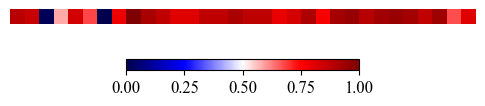

In [17]:
%matplotlib inline
filters = model1.state_dict()['final.1.weight'].cpu()
f_min, f_max = filters.min(), filters.max()
filters = (filters -f_min)/(f_max-f_min)
plt.figure(figsize=(6, 3))
plt.axis('off')
plt.imshow(filters.reshape(1, 32), cmap='seismic')
plt.colorbar(shrink=0.5, aspect=20, orientation='horizontal')

In [18]:
#val_data = np.array(val_data)
val_truth = []
val_predict = [] 
val_truth_d = []
for p, q  in enumerate(val_data):
    for i, j  in enumerate(q[1]):
        val_truth.append(j.cpu().numpy())
    for i, j  in enumerate(q[0]):
        val_predict.append(j.cpu().numpy())
    for i, j  in enumerate(q[2]):
        val_truth_d.append(j.cpu().numpy())

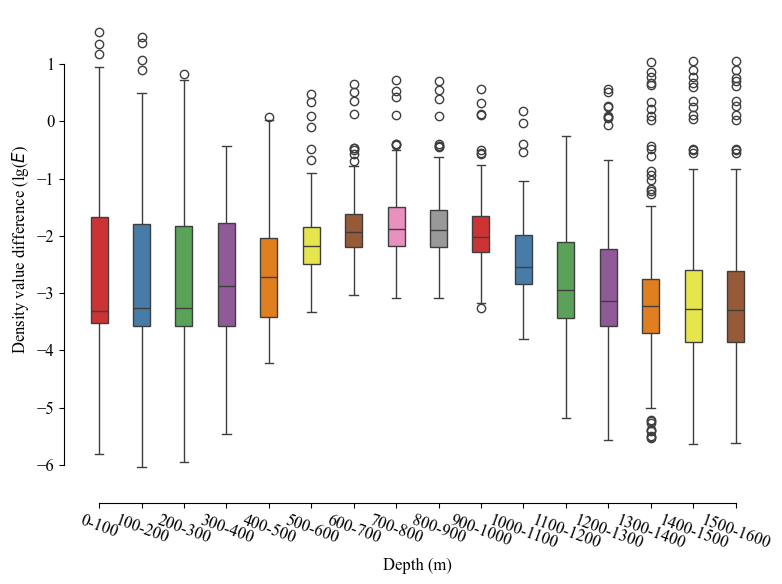

In [19]:
ddiff = np.zeros((val_num, 16))
for j in range(0, 32, 2):
    n = int(0.5*j)
    for i in range(val_num):
        a = val_predict[i].reshape(32, num_cell, num_cell)[j: j+2]
        b = val_truth[i].reshape(32, num_cell, num_cell)[j: j+2]
        ddiff[i, n] = np.mean(np.power(a-b, 2)+1e-3)/np.mean(np.power(b, 2)+1e-3)
ddiff = pd.DataFrame(ddiff)
ddiff.columns = ['0-100','100-200', '200-300', '300-400', '400-500', '500-600', '600-700', '700-800','800-900', '900-1000', '1000-1100', '1100-1200', '1200-1300', '1300-1400', '1400-1500', '1500-1600']
ddiff = np.log(ddiff)

plt.figure(figsize=(8, 6))
sns.boxplot(data=ddiff, width=0.4, palette='Set1')
sns.despine(offset=10, trim=True)
plt.xticks(rotation=-20)
plt.xlabel('Depth (m)')
plt.ylabel('Density value difference (lg($\it{E}$)')
plt.tight_layout()

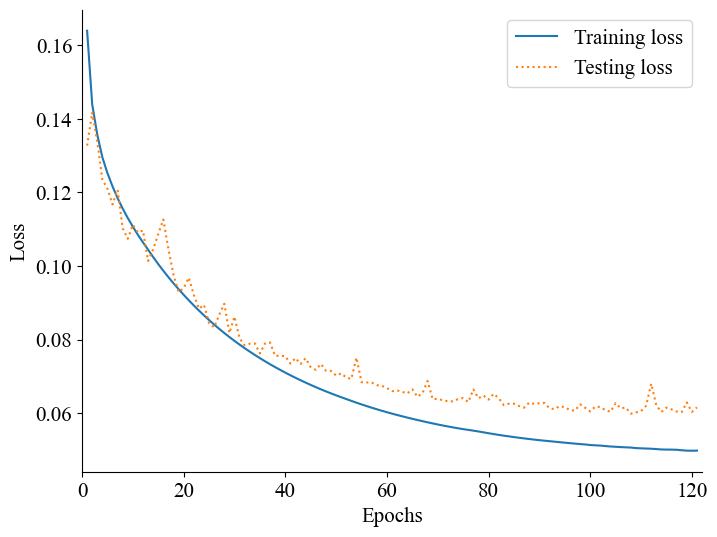

In [20]:
plt.figure(figsize=(8, 6))
plt.rcParams['font.size'] = 15
X = range(1, epoch+1)

mean_tra_losses_tensor = torch.tensor(mean_tra_losses)
mean_val_losses_tensor = torch.tensor(mean_val_losses)

plt.plot(X, mean_tra_losses_tensor)
plt.plot(X, mean_val_losses_tensor, linestyle=':')
sns.despine(offset=0, trim=False)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Training loss", "Testing loss"], loc='best')

plt.xlim(0, epoch+1)  # 设置横坐标范围从0到epoch+1

# 设置保存路径和文件名
save_path = 'C:/Users/dell/Desktop/123'
file_name = 'loss.png'

# 设置分辨率
dpi = 720

# 拼接完整的保存路径
save_file = os.path.join(save_path, file_name)

# 保存图像
plt.savefig(save_file, dpi=dpi)

In [26]:
index = 33
m1 = val_truth[index]
m2 = val_predict[index]
m3 = (m2 > 0.5).astype(np.uint8)
tru_g = val_truth_d[index]

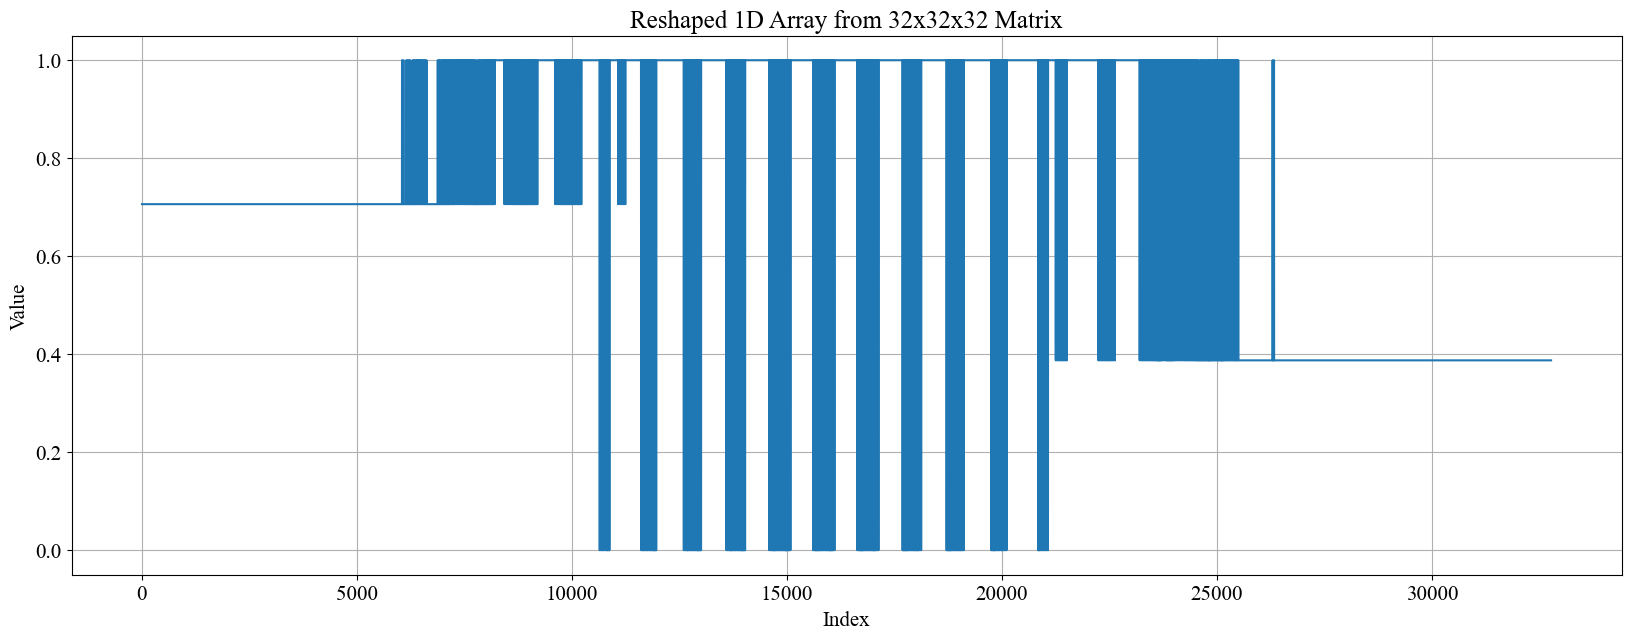

In [27]:
reshaped_array = m1.reshape(-1)
reshaped_array.shape
plt.figure(figsize=(20, 7))
plt.plot(reshaped_array)
plt.title('Reshaped 1D Array from 32x32x32 Matrix')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid()
plt.show()

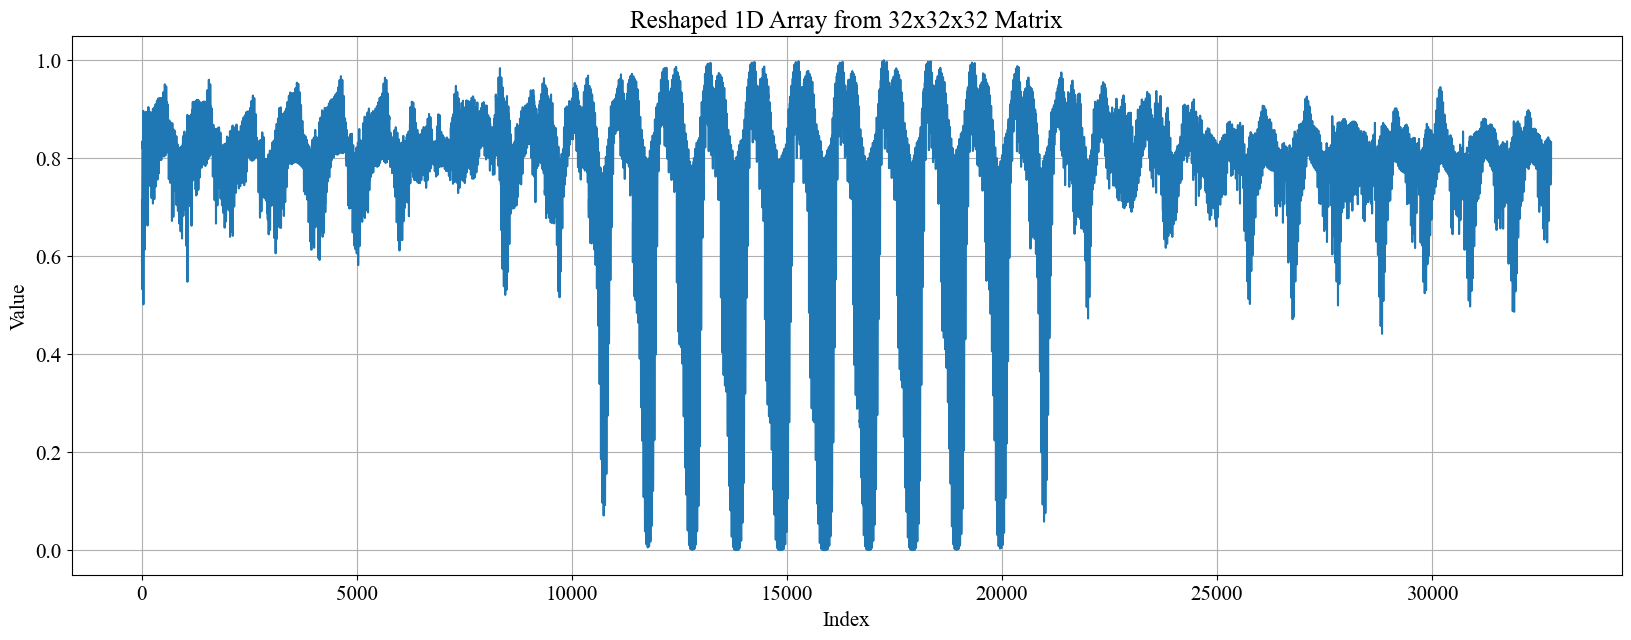

In [28]:
matrix_min = m2.min()
matrix_max = m2.max()
m4 = (m2 - matrix_min) / (matrix_max - matrix_min)
reshaped_array = m4.reshape(-1)
reshaped_array.shape
plt.figure(figsize=(20, 7))
plt.plot(reshaped_array)
plt.title('Reshaped 1D Array from 32x32x32 Matrix')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid()
plt.show()

In [29]:
from scipy.io import savemat
savemat('33_duibi_ji.mat', {'val_truth_duibi': m1, 'val_predict_duibi': m4})
